Importing all the libraries

In [167]:
import pandas as pd
import numpy as np
import yfinance as yf 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, Markdown
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

Importing the class to download crypto data

In [3]:
from cryptodatadownloader import CryptoDataDownloader

-----

Downloading Weekly crypto data

In [5]:
tickers = ["bitcoin","ethereum",
            "solana","binancecoin","ripple",
            "cardano","avalanche-2","dogecoin",
            "polkadot","matic-network","tron",
            "chainlink","litecoin","cosmos"] 
downloader = CryptoDataDownloader(tickers, 'usd')
crypto_data = downloader.download_data('W')

Rate limit hit for cardano. Waiting for 3 seconds before retrying...
Rate limit hit for cardano. Waiting for 6 seconds before retrying...
Rate limit hit for cardano. Waiting for 12 seconds before retrying...
Rate limit hit for cardano. Waiting for 24 seconds before retrying...
Rate limit hit for tron. Waiting for 3 seconds before retrying...
Rate limit hit for tron. Waiting for 6 seconds before retrying...
Rate limit hit for tron. Waiting for 12 seconds before retrying...
Rate limit hit for tron. Waiting for 24 seconds before retrying...


In [6]:
len(crypto_data) == len(tickers) #verifying that all the assets where downloaded

True

In [7]:
crypto_data['bitcoin'].head(2) #example of how the downloaded data looks

,W Average Price,W Average Market Cap
timestamp,,
2013-04-28,135.300000,1.500518e+09
2013-05-05,116.677143,1.295729e+09


-----

## Preparing the Data

For this project, 170 weeks of return data will be used, the reason behind this number is that data for some assets is not available because the projects didn't exist yet. <br>
The chosen assets have the highest market capitalization in the crypto ecosystem.

Returns:

In [8]:
returns_df = pd.DataFrame()
for ticker in tickers:
    returns_df[ticker] = crypto_data[ticker].loc[:,'W Average Price'].tail(171).pct_change()[1:]
returns_df.head(2)

,bitcoin,ethereum,solana,binancecoin,ripple,cardano,avalanche-2,dogecoin,polkadot,matic-network,tron,chainlink,litecoin,cosmos
timestamp,,,,,,,,,,,,,,
2020-10-18,0.052589,0.064649,-0.036076,0.075612,-0.003923,0.095174,0.088985,0.003834,0.014634,-0.012674,0.015365,0.135796,0.047795,0.122406
2020-10-25,0.087355,0.044497,-0.151631,-0.007025,0.003652,0.001855,-0.026796,-0.003341,0.001252,-0.031438,0.000961,0.040000,0.055564,-0.064307


In [9]:
returns_df.shape

(170, 14)

Covariance Matrix: To annualize the covariance matrix calculated from weekly returns, you multiply it by a scaling factor. Since there are typically 52 weeks in a year, the scaling factor is 52. This assumes that returns are independent and identically distributed over time.

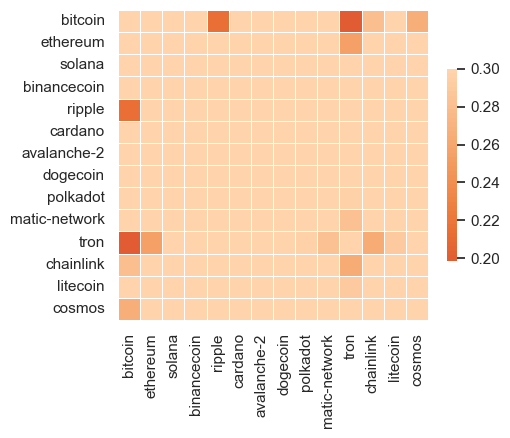

In [16]:
sigma = returns_df.cov()
# Visualize the covariance matrix
sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(sigma*52,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

plt.show()

------

Risk Free Rate

For this project, the risk-free rate will be used for computations such as CAPM and Sharpe ratio. It will be assumed 0, for simplicity.

In [17]:
rf = 0
rf

0

----------

## Getting Implied Equilibrium Returns: the Prior

The Black-Litterman model starts with what's called "equilibrium returns." 
These are the returns needed to balance the market. 
To find these returns, a method called reverse optimization is used. 
This method takes known information and uses a special formula (1) to figure out the equilibrium returns.

$$
\Pi = \lambda \Sigma \mathbf{w}_{\text{mkt}}\tag{1}
$$                
where 
- $\Pi$ is the Implied Excess Equilibrium Return Vector (N x 1 column vector),
- $\lambda$ is the risk aversion coefficient,
- $\Sigma$ is the covariance matrix of excess returns (N x N matrix), and
- $\mathbf{w}_{\text{mkt}}$ is the market capitalization weight (N x 1 column vector) of the assets.


Writings about the Black-Litterman Model frequently mention that the Implied Equilibrium Return Vector (Π) corresponds to the CAPM returns vector. However, it is important to note that this is the case only if the CAPM returns vector is based on implied betas. When you calculate CAPM returns using these implied betas, which are relative to a portfolio weighted by market capitalization, they align with the reverse optimized return vector.\
This is the method that will be used.

--------

Computing Market Capitalization Weights

$$
\mathbf{w}_{\text{mkt_i}} = \frac{\text{Average Market Cap of Asset } i}{\sum_{j=1}^{n} \text{Average Market Cap of Asset } j}
$$


In [18]:
total_mktcap = 0
for ticker in tickers:
    total_mktcap=total_mktcap + np.mean(crypto_data[ticker].loc[:,'W Average Market Cap'].tail(171))


w_mktcap = pd.DataFrame()
for ticker in tickers:
    avg_mktcap = np.mean(crypto_data[ticker]['W Average Market Cap'].tail(171))
    w_mktcap.loc[ticker, 'MktCap Weight', ] = avg_mktcap / total_mktcap    

In [19]:
w_mktcap

,MktCap Weight
bitcoin,0.594589
ethereum,0.227982
solana,0.015973
binancecoin,0.044789
ripple,0.027619
cardano,0.023560
avalanche-2,0.007068
dogecoin,0.014431
polkadot,0.014329
matic-network,0.006508


---------

#### Computing Market Capitalization-Weighted portfolio returns

In [13]:
w_mktcap.shape

(14, 1)

In [14]:
returns_df.shape

(170, 14)

In [20]:
mktcap_portfolio = returns_df@w_mktcap
mktcap_portfolio.columns = ['Return']
mktcap_portfolio.head()

,Return
timestamp,
2020-10-18,0.053538
2020-10-25,0.059474
2020-11-01,0.040873
2020-11-08,0.051841
2020-11-15,0.093746


Expected Return:

In [21]:
avg_mktcap_portfolio = np.mean(mktcap_portfolio)
avg_mktcap_portfolio

C:\Users\Martin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Return    0.013995
dtype: float64

-----------

#### Computing the Implied Betas

The Implied Betas are the Betas of the N assets relative to the market cap- weighted portfolio.

$$
\beta = \frac{\Sigma w_{\text{mkt}}}{w_{\text{mkt}}^T \Sigma w_{\text{mkt}}} = \frac{\Sigma w_{\text{mkt}}}{\sigma^2}
$$

where

- $\beta$ is the vector of implied betas (N,1);
- $\Sigma$ is the covariance matrix of excess returns (N,N);
- $w_{\text{mkt}}$ is the market capitalization weights (N,1); and,
- $\sigma^2 = w_{\text{mkt}}^T \Sigma w_{\text{mkt}} = \frac{1}{\beta^T \Sigma^{-1} \beta}$ is the variance of the market (or benchmark) excess returns.


In [22]:
implied_beta = (np.array(sigma)@np.array(w_mktcap))/(np.array(w_mktcap.T)@np.array(sigma)@np.array(w_mktcap))
np.round(implied_beta, 2)

array([[0.92],
       [1.1 ],
       [1.3 ],
       [1.12],
       [0.89],
       [1.17],
       [1.56],
       [1.53],
       [1.09],
       [1.23],
       [0.72],
       [0.99],
       [1.02],
       [0.98]])

--------

CAPM relative to the market capitalization-weighted portfolio

The Capital Asset Pricing Model (CAPM) is given by the formula:

$$
E(R_i) = R_f + \beta_i (E(R_m) - R_f)
$$

where:
- $ E(R_i)$ is the expected return on asset i,
- $ R_f$ is the risk-free rate of return,
- $ \beta_i $ is the beta of the asset,
- $E(R_m) $ is the expected return of the market.


The $ \beta_i $ will correspond in this case to the implied beta of asset i. \
By applying the formula to the data, we get the Implied Return Vector:

In [23]:
implied_return = pd.DataFrame(index=tickers, columns=['Implied Return'])

for i, ticker in enumerate(tickers):
    implied_return.loc[ticker, 'Implied Return'] = float(rf + implied_beta[i] * (float(avg_mktcap_portfolio) - rf))

print(implied_return['Implied Return'].apply(lambda x: round(x, 4)*100))

bitcoin          1.29
ethereum         1.54
solana           1.82
binancecoin      1.56
ripple           1.25
cardano          1.64
avalanche-2      2.18
dogecoin         2.14
polkadot         1.53
matic-network    1.72
tron             1.01
chainlink        1.39
litecoin         1.42
cosmos           1.37
Name: Implied Return, dtype: float64


-------

Recommended Portfolio Weights

From $\Pi = \lambda \Sigma w_{\text{mkt}}$, we can substitute $\Pi$ (Implied Return Vector) for $\mu$, which represents any vector of excess returns.

We get:

$$
w = (\lambda \Sigma)^{-1} \mu \quad (2)
$$

Which is the solution to the unconstrained maximization problem:

$$
\max_w w' \mu - \frac{\lambda}{2} w' \Sigma w
$$

if $ \mu = \Pi, w = w_{\text{mkt}}$.

The risk-aversion coefficient (λ ) characterizes the expected risk-return tradeoff: 
$$
\lambda = \frac{E(r) - r_f}{\sigma^2}
$$

where

- $E(r)$ is the expected market cap-weighted portfolio return,
- $r_f$ is the risk-free rate,
- $\sigma^2 = w_{\text{mkt}}^T \Sigma w_{\text{mkt}}$  is the variance of the market market cap-weighted portfolio excess returns.

Based on the previous information, we can compute $\lambda$ and then the recommended weights:

In [24]:
lam = float( (float(avg_mktcap_portfolio) - rf )/float((np.array(w_mktcap.T)@np.array(sigma)@np.array(w_mktcap))))
round(lam,4)

2.1579

In [25]:
weights_pi = np.linalg.inv(lam*np.array(sigma))@np.array(implied_return)
print(pd.DataFrame(np.around(weights_pi.astype(float),4), index=tickers, columns= ['Weight Based on Implied Equilibrium Return Vector ']))

               Weight Based on Implied Equilibrium Return Vector 
bitcoin                                                   0.5946 
ethereum                                                  0.2280 
solana                                                    0.0160 
binancecoin                                               0.0448 
ripple                                                    0.0276 
cardano                                                   0.0236 
avalanche-2                                               0.0071 
dogecoin                                                  0.0144 
polkadot                                                  0.0143 
matic-network                                             0.0065 
tron                                                      0.0057 
chainlink                                                 0.0063 
litecoin                                                  0.0072 
cosmos                                                    0.0040 


-------

### Comparison with other methods: Historical & BITWISE CAPM

------

Historical mu:

In [26]:
historical_df = pd.DataFrame()
for ticker in tickers:
    historical_df.loc[ticker, 'mu'] = np.mean(returns_df[ticker])
print(historical_df)

                     mu
bitcoin        0.011433
ethereum       0.015719
solana         0.034832
binancecoin    0.020664
ripple         0.013649
cardano        0.016812
avalanche-2    0.029241
dogecoin       0.039573
polkadot       0.009766
matic-network  0.035183
tron           0.011975
chainlink      0.007940
litecoin       0.007029
cosmos         0.010832


Weights using formula (2):

In [27]:
weights_historical = np.linalg.inv(lam*np.array(sigma))@np.array(historical_df)

------

CAPM relative to BITWISE index

The Bitwise 10 Crypto Index Fund, marked with the ticker “BITW,” offers a secure way to gain diversified exposure to Bitcoin and other leading cryptocurrencies. It aims to track an index consisting of the 10 most highly valued cryptocurrencies, which are selected based on market capitalization.  As of December 27, 2023, the fund's major holdings included Bitcoin, Ethereum, Solana, XRP, Cardano, Avalanche, Polkadot, Polygon, Chainlink, and Litecoin, with Bitcoin making up 66% of the portfolio.

In [29]:
# Loading the data into a DataFrame
bitwise_df = pd.read_csv('MVDA10_history.txt', sep=';', parse_dates=['date'], index_col='date')

In [30]:
weekly_mkt_returns = bitwise_df['MVDA10'].resample('W').ffill().pct_change()[1:]

In [31]:
beta = pd.DataFrame()
for ticker in tickers:
    Y = returns_df[ticker] - rf
    market_excess = weekly_mkt_returns.tail(170) - rf
    # Make sure both Series are aligned by index before regression
    aligned_Y, aligned_market_excess = Y.align(market_excess, join='inner')
    # Adding a constant for regression
    X = sm.add_constant(aligned_market_excess)
    # Fit the model
    model = sm.OLS(aligned_Y, X).fit()
    # Store the beta coefficient
    beta.loc[ticker, 'Beta'] = model.params[1]
beta=beta['Beta']    

In [42]:
capm_returns = pd.DataFrame()
for ticker in tickers:
    capm_returns.loc[ticker, 'MVDA10 CAPM'] = rf + beta[ticker]*(np.mean(weekly_mkt_returns.tail(170))-rf)

Weights using (2):

In [33]:
weights_bitwise = np.linalg.inv(lam*np.array(sigma))@np.array(capm_returns)

-------

### Comparative table for the returns, in %

In [34]:
np.array(implied_return)

array([[0.01290456914084416],
       [0.015367485402670134],
       [0.01822111569119699],
       [0.015620523661678919],
       [0.01252019056256568],
       [0.016363077808001645],
       [0.021839033154535958],
       [0.0214296183582652],
       [0.015322830410688501],
       [0.017203926744921907],
       [0.010053560045592958],
       [0.013879747041276487],
       [0.014249884157607931],
       [0.0136506214584115]], dtype=object)

In [41]:
# Convert to numpy array, multiply by 100, round, and then convert to string and add '%'
historical_percent = ['{:.2f}%'.format(x * 100) for x in np.array(historical_df).flatten()]
capm_returns_percent = ['{:.2f}%'.format(x * 100) for x in np.array(capm_returns).flatten()]
implied_return_percent = ['{:.2f}%'.format(x * 100) for x in np.array(implied_return['Implied Return']).flatten()]

# Create the DataFrame with percentages
table1 = pd.DataFrame({
    'Historical mu': historical_percent,
    'MVDA10 CAPM mu': capm_returns_percent,
    'Implied Return pi': implied_return_percent,
}, index=tickers)

# Print the DataFrame
print(table1)

              Historical mu MVDA10 CAPM mu Implied Return pi
bitcoin               1.14%          0.71%             1.29%
ethereum              1.57%          0.91%             1.54%
solana                3.48%          0.99%             1.82%
binancecoin           2.07%          0.84%             1.56%
ripple                1.36%          0.62%             1.25%
cardano               1.68%          0.83%             1.64%
avalanche-2           2.92%          1.15%             2.18%
dogecoin              3.96%          1.12%             2.14%
polkadot              0.98%          0.82%             1.53%
matic-network         3.52%          0.92%             1.72%
tron                  1.20%          0.54%             1.01%
chainlink             0.79%          0.81%             1.39%
litecoin              0.70%          0.80%             1.42%
cosmos                1.08%          0.79%             1.37%


-------

### Comparative table for the weights, in %

In [40]:
# Convert to numpy array, round to four decimal places, multiply by 100 for percentage, and then convert to string and add '%'
historical_w_percent = ['{:.2f}%'.format(x * 100) for x in np.array(weights_historical).flatten()]
bitw_w_percent = ['{:.2f}%'.format(x * 100) for x in np.array(weights_bitwise).flatten()]
implied_returns_w_percent = ['{:.2f}%'.format(x * 100) for x in np.around(weights_pi.astype(float), 4).flatten()]
mkt_cap_w_percent = ['{:.2f}%'.format(x * 100) for x in np.array(w_mktcap).flatten()]

# Create the DataFrame with percentages
table2 = pd.DataFrame({
    'Historical w': historical_w_percent,
    'MVDA10 w': bitw_w_percent,
    'Implied Returns w': implied_returns_w_percent,
    'Mkt Cap w' : mkt_cap_w_percent
}, index=tickers)

# Print the DataFrame
print(table2)

              Historical w MVDA10 w Implied Returns w Mkt Cap w
bitcoin             82.32%   25.18%            59.46%    59.46%
ethereum            49.87%   27.12%            22.80%    22.80%
solana              43.07%    1.18%             1.60%     1.60%
binancecoin         27.94%    5.02%             4.48%     4.48%
ripple              -3.37%   -0.87%             2.76%     2.76%
cardano            -46.42%   -4.05%             2.36%     2.36%
avalanche-2         14.23%    0.41%             0.71%     0.71%
dogecoin            18.56%   -0.77%             1.44%     1.44%
polkadot           -38.50%   -5.82%             1.43%     1.43%
matic-network       32.33%   -0.32%             0.65%     0.65%
tron                32.70%   -0.69%             0.57%     0.57%
chainlink          -26.62%    3.41%             0.63%     0.63%
litecoin           -79.74%    0.91%             0.72%     0.72%
cosmos             -25.37%    4.58%             0.40%     0.40%


--------

Some insightful statistics

In [37]:
historical_weighted_avg= weights_historical.T@historical_df
bitwise_weighted_avg=weights_bitwise.T@capm_returns
implied_weighted_avg = weights_pi.T@implied_return

historical_std = np.std(historical_df)
bitwise_std = np.std(capm_returns)
implied_std = np.std(implied_return)

In [43]:
# Round to four decimal places, multiply by 100 for percentage, and format as strings with '%'
historical_values = ['{:.2f}%'.format(x * 100) for x in [np.array(historical_weighted_avg).flatten()[0], np.array(historical_std).flatten()[0]]]
bitwise_values = ['{:.2f}%'.format(x * 100) for x in [np.array(bitwise_weighted_avg).flatten()[0], np.array(bitwise_std).flatten()[0]]]
implied_values = ['{:.2f}%'.format(x * 100) for x in [np.array(implied_weighted_avg).flatten()[0], np.array(implied_std).flatten()[0]]]

# Create the DataFrame with formatted percentage strings
table3 = pd.DataFrame({
    'Historical': historical_values,
    'MVDA10 CAPM': bitwise_values,
    'Implied Returns': implied_values,
}, index= ['Weighted Average', 'Std. Deviation'])

# Print the DataFrame
print(table3)

                 Historical MVDA10 CAPM Implied Returns
Weighted Average      4.23%       0.45%           1.40%
Std. Deviation        1.07%       0.16%           0.32%


------

## The Black-Litterman model

Now that we have our prior, we will start computing the posterior, by first introducing the Black-Litterman model.

The formula for the new Combined Return Vector \( E[R] \) is:

$$
E[R] = \left[ (\tau \Sigma)^{-1} + P'\Omega^{-1}P \right]^{-1} \left[ (\tau \Sigma)^{-1}\Pi + P'\Omega^{-1}Q \right]
$$

where

- $E[R]$ is the new (posterior) Combined Return Vector ($N \times 1$);
- $\tau$ is a scalar;
- $\Sigma$ is the covariance matrix of excess returns ($N \times N$);
- $P$ is a matrix that identifies the assets involved in the views ($K \times N$) or $(1 \times N$) in the special case of 1 view);
- $\Omega$ is a diagonal covariance matrix of error terms from the views, representing the uncertainty in each view ($K \times K$);
- $ \Pi $ is the Implied Equilibrium Return Vector ($N \times 1$); 
- $Q$ is the View Vector ($K \times 1$).


--------

#### Investor Views

Views from an investor can be either absolute, e.g: Bitcoin will grow 30%, or relative, e.g: Ethereum will outperform Bitcoin by 10%.

It is not required to specify views on all assets.

There are different methods to incorporate the views using the matrix P. However, in this project we'll focus on the market capitalization weighting scheme. The reason behind this choice is that other methods may result in undesired tracking error.\
Using this method, the relative weight of each individual asset is proportional to the asset's market capitalization divided by the total market capitalization of either the outperforming or underperformin assets of that particular view. \
In the case where the view is absolute, the used weight in the matrix P is 1, because non of the other assets are involved. <br>
In the case of relative views, each row sums to 0. 

**General Case:**

The matrix \( P \) is defined as:

$$
P = \begin{bmatrix}
p_{1,1} & \dots & p_{1,n} \\
\vdots & \ddots & \vdots \\
p_{k,1} & \dots & p_{k,n}
\end{bmatrix}
$$

**Example:**

$$
P = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
-1 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0.9 & -0.9 & 0.1 & -0.1 & 0 \\
\end{bmatrix}
$$


In this example, we have a (3x7) matrix, which means that there are 3 views, and the portfolio is made of 7 assets.<br><br>
The 1st row has a 1 in the 6th column, which corresponds to an absolute view on the 6th asset of the portfolio.<br><br>
The 2nd row has a -1 and a 1, in the 1st and 2nd column, respectively. The underperforming asset(Asset 1) has a negative value and the outperforming asset (Asset 2) has a positive value. Since there are only two assets involved, the market capitalization weighting sheme is not being used.

For the 3rd row, the market capitalization weighting scheme is being used:<br><br>
Let's say that Asset 3 and 4 have a market cap of $\$$90 million and Asset 5 and 6 have a market cap of $\$$10 million.<br>
Let's assume, from an investor's view, that Asset 3 & 5 will outperform Asset 4 & 6. Note that the 'quantity' of the outperformance is not needed for P. <br> <br>
To compute the weights for P, we grab the outperforming assets and compute their relative weight(by market cap). We do the same for the set of underperforming assets. 

We have: <br>
<br>
\$
\text{Asset 3 relative weight} = \frac{90\text{ million}}{90\text{ million} + 10\text{ million}} = 0.9
\$

\$
\text{Asset 5 relative weight} = \frac{10\text{ million}}{90\text{ million} + 10\text{ million}} = 0.1
\$<br>
<br>
Since those two assets are outperformers, the sign stays positive. <br>
Assets 4 and 6 have the same computation (in this example), however since they are underperformers, the sign becomes negative.

Now that we have explained how to incorporate the views, let's apply it to the project.

The following is a list of sample views:

#### Cryptocurrency Predictions for 2024

1. **Bitcoin (BTC)**: 
   - *Absolute View*: Expected growth of 100% (Annualized).

2. **Ethereum (ETH) vs. Bitcoin (BTC)**: 
   - *Relative View*: Ethereum might outperform Bitcoin by 40%.

3. **Solana (SOL) and Binance Coin (BNB) vs. Cardano (ADA) and Polkadot (DOT)**: 
   - *Relative View*: Solana and Binance Coin could outperform Cardano and Polkadot, by 20%.
   
4. **Polygon (Matic Network) vs. Chainlink (LINK)**: 
   - *Relative View*: Polygon likely to outperform Chainlink by 50%.

We have 4 views and 14 assets, so P is a (4x14) matrix. <br> 
First row corresponds to View 1, second to View 2 and so on.<br>
The matrix P looks like this: <br>

$$
P = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
-1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & c & d & 0 & -e & 0 & 0 & -f & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -1 & 0 & 0 \\
\end{bmatrix}
$$


Now we have to compute a, b, c,..., i  using the market capitalizations of each asset and P will be ready <br>
Since we have 171 weeks of data, we will use the average market cap.

View 3:

In [44]:
sol_avg_mktcap = np.mean(crypto_data['solana'].loc[:,'W Average Market Cap'].tail(171))
bnb_avg_mktcap = np.mean(crypto_data['binancecoin'].loc[:,'W Average Market Cap'].tail(171))
ada_avg_mktcap = np.mean(crypto_data['cardano'].loc[:,'W Average Market Cap'].tail(171))
dot_avg_mktcap = np.mean(crypto_data['polkadot'].loc[:,'W Average Market Cap'].tail(171))

c = sol_avg_mktcap/(sol_avg_mktcap+bnb_avg_mktcap)
d = bnb_avg_mktcap/(sol_avg_mktcap+bnb_avg_mktcap)
e = ada_avg_mktcap/(ada_avg_mktcap+dot_avg_mktcap)
f = dot_avg_mktcap/(ada_avg_mktcap+dot_avg_mktcap)

round(c+d-e-f,10)

-0.0

In [45]:
P = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0,  c, d, 0, -e, 0, 0, -f, 0, 0, 0, 0, 0],
              [0, 0,  0, 0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0]])

In [46]:
P.shape

(4, 14)

In [47]:
round(c,2), round(d,2), round(e,2), round(f,2)

(0.26, 0.74, 0.62, 0.38)

Result:
$$
P = \begin{bmatrix}
1 & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
-1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0.26 & 0.74 & 0 & -0.62 & 0 & 0 & -0.38 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -1 & 0 & 0 \\
\end{bmatrix}
$$


------

#### Variance of the Views $ \mathbf{p}_k \Sigma \mathbf{p}_k^T $

After computing P, we can now compute the variance of the views. <br>
The individual variance associated with each view  provides insight about the level of confidence, or the absence of it, one might have in a particular view. This information will soon be utilized to compute the variances of the error terms (ω), which are the diagonal components of the matrix Ω. <br><br>
The variance of an individual view  is $ \mathbf{p}_k \Sigma \mathbf{p}_k^T $, <br>
where $ \mathbf{p}_k $ is a $ 1 \times N $ row vector from Matrix $ \mathbf{P} $ that corresponds to the $ k $th view <br>and $ \Sigma $ is the covariance matrix of excess returns.

Let's compute them:

In [48]:
k = 4
view_variance = pd.DataFrame()
for i in range(k):
    p_row = P[i].reshape(1, -1)  # Reshape the i-th row of P to a 1xN array
    variance = np.array(p_row @ sigma @ p_row.T)  # Calculate the variance
    view_variance.loc[i, 'Variance'] = variance.item() 
view_variance.index = [1,2,3,4]

In [49]:
view_variance

,Variance
1,0.006018
2,0.003596
3,0.006301
4,0.028365


The following table encapsulates the results:

\begin{array}{|c|c|c|}
\hline
\textbf{View} & \textbf{Formula} & \textbf{Variance} \\
\hline
1 & p_1 \Sigma p_1' & 0.6018\% \\
\hline
2 & p_2 \Sigma p_2' & 0.3596\% \\
\hline
3 & p_3 \Sigma p_3' & 0.6301\% \\
\hline
4 & p_4 \Sigma p_4' & 2.8365\% \\
\hline
\end{array}


---------

#### View Vector Q

The uncertainty of the views corresponds to an Error Term Vector $ \boldsymbol{\varepsilon} $ with mean 0 and covariance $ \Omega $. Thus, a view has the form $ \mathbf{Q} + \boldsymbol{\varepsilon} $.
<br>
The Error Term Vector (ε ) does not directly enter the Black-Litterman formula, it is the variance of each error term  (ω ) that enters into the formula.

It is easy to input the views, for example View 1 says that bitcoin will increase 30%, so the 1st row of Q is 30.

In [50]:
# Dimension: (Kx1) so here (5x1).
# Views are annualized, so we need to convert them to weekly.
Q = np.array([[(1+1)**(1/52) - 1],[(1+0.4)**(1/52) - 1],[(1+0.2)**(1/52) - 1],[(1+0.5)**(1/52) - 1]])
Q.shape

(4, 1)

The view vector along with it's error term, look like this:

$$
\mathbf{Q} + \boldsymbol{\varepsilon} = 
\begin{bmatrix}
View_1 \\
View_2 \\
View_3 \\
View_4 \\
\end{bmatrix}
+ 
\begin{bmatrix}
\varepsilon_1 \\
\varepsilon_2 \\
\varepsilon_3 \\
\varepsilon_4 \\
\end{bmatrix}
$$

-------

#### Uncertainty of the views


The Black-Litterman model represents a mix of the Implied Equilibrium Return Vector (Π) and the View Vector (Q), where the balance between them depends on the scalar (τ) and the uncertainty associated with the views (Ω). <br> <br>
The higher the confidence towards the views, the closer the posterior E(R) will be to the views. Conversely, the lower the level of confidence towards the views, the closer the posterior E(R) will be to the Implied Equilibrium Returns (Π).


There are different methods to set the value of the scalar τ. The easiest way is to make an assumption about the value.<br>

The variances of the error terms (ω) represent the 
uncertainty of the views. The larger $\omega_k$, the greater the 
uncertainty of the view k. 


In addition, He and Litterman (1999) calibrate the confidence of a view so that the ratio  $ \omega $ / $ \tau $ is equal to the variance of the view k,  $ \mathbf{p}_k \Sigma \mathbf{p}_k' $. <br>

This method allows investors to focus more on the accuracy of their views (Q), rather than fine-tuning τ.


The matrix Ω has the following form:


$$
\Omega = 
\begin{bmatrix}
\omega_1 & 0 & 0 \\
0 & \ddots & 0 \\
0 & 0 & \omega_k
\end{bmatrix}
=
\begin{bmatrix}
(p_1 \Sigma p_1') \cdot \tau & 0 & \cdots & 0 \\
0 & \ddots & & \vdots \\
\vdots & & \ddots & 0 \\
0 & \cdots & 0 & (p_k \Sigma p_k') \cdot \tau
\end{bmatrix}
$$


Let's compute it:

In [51]:
tao = 0.025 # Assumption on th scalar, can be what we want
# reminder: omega is (KxK) so here we have (5x5).

# Define the number of views
num_views = P.shape[0]

# Create an omega array of zeros with the shape (num_views, num_views)
omega = np.zeros((num_views, num_views))

# Calculate the variance for each view and assign it to the diagonal of omega
for i in range(num_views):
    p_i = P[i].reshape(1, -1)
    variance = np.array((p_i @ sigma @ p_i.T)).item() * tao  # Use .item() to get a scalar value
    omega[i, i] = variance


In [52]:
np.round(omega,5)

array([[1.5e-04, 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 9.0e-05, 0.0e+00, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.6e-04, 0.0e+00],
       [0.0e+00, 0.0e+00, 0.0e+00, 7.1e-04]])

Result using $\tau$=0.025 :

$$
\Omega =
\begin{bmatrix}
0.00015 & 0 & 0 & 0  \\
0 & 0.00009 & 0 & 0 \\
0 & 0 & 0.000155 & 0 \\
0 & 0 & 0  & 0.000711 
\end{bmatrix}
$$

--------

#### Calculating the New Combined Return Vector

We have all the inputs ready to compute E(R): <br>
$$
E[R] = \left[ (\tau \Sigma)^{-1} + P'\Omega^{-1}P \right]^{-1} \left[ (\tau \Sigma)^{-1}\Pi + P'\Omega^{-1}Q \right]
$$

In [53]:
np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(omega)@P)
( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(omega)@Q)
new_return = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(omega)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(omega)@Q)

In [54]:


results1_df = pd.DataFrame({
    'New Combined Return E(R)': new_return.flatten(),
    'Implied Equilibrium Return Π': np.array(implied_return).flatten(),
    'Difference E(R)-Π': new_return.flatten() - np.array(implied_return).flatten(),
}, index=tickers)

# Format the numbers to round them to two decimal places and convert to percentage
results1_df['New Combined Return E(R)'] = results1_df['New Combined Return E(R)'].apply(lambda x: f"{x:.2%}")
results1_df['Implied Equilibrium Return Π'] = results1_df['Implied Equilibrium Return Π'].apply(lambda x: f"{x:.2%}")
results1_df['Difference E(R)-Π'] = results1_df['Difference E(R)-Π'].apply(lambda x: f"{x:.2%}")

print(results1_df)


              New Combined Return E(R) Implied Equilibrium Return Π  \
bitcoin                          1.32%                        1.29%   
ethereum                         1.76%                        1.54%   
solana                           2.15%                        1.82%   
binancecoin                      1.79%                        1.56%   
ripple                           1.41%                        1.25%   
cardano                          1.76%                        1.64%   
avalanche-2                      2.37%                        2.18%   
dogecoin                         2.57%                        2.14%   
polkadot                         1.63%                        1.53%   
matic-network                    2.10%                        1.72%   
tron                             1.13%                        1.01%   
chainlink                        1.51%                        1.39%   
litecoin                         1.54%                        1.42%   
cosmos

As you can see, the New Combined Return Vector is different from the Implied Equilibrium Vector, this is because of the added information: the views.

------

#### New Recommended Weights $ \hat{\omega} $


We apply formula (2) and we get:

In [55]:
weights_new = np.linalg.inv(lam*np.array(sigma))@new_return

In [56]:
results2_df = pd.DataFrame({
    'New Recommended Weights': weights_new.flatten(),
    'Implied Return Weights(Mkt Cap Weights)': weights_pi.flatten(),
    'Difference' : weights_new.flatten() - weights_pi.flatten(),
}, index=tickers)

# Format the numbers to round them to two decimal places and convert to percentage
results2_df['New Recommended Weights'] = results2_df['New Recommended Weights'].apply(lambda x: f"{x:.2%}")
results2_df['Implied Return Weights(Mkt Cap Weights)'] = results2_df['Implied Return Weights(Mkt Cap Weights)'].apply(lambda x: f"{x:.2%}")
results2_df['Difference'] = results2_df['Difference'].apply(lambda x: f"{x:.2%}")

results2_df.loc['Sum','New Recommended Weights'] = str(round(np.sum(weights_new)*100, 2)) + '%'
results2_df.loc['Sum','Implied Return Weights(Mkt Cap Weights)'] = str(round(np.sum(weights_pi)*100,2)) + '%'
results2_df.loc['Sum','Difference'] = str(round(np.sum(weights_new)*100 - np.sum(weights_pi)*100,2))+ '%'
print(results2_df)

              New Recommended Weights Implied Return Weights(Mkt Cap Weights)  \
bitcoin                        34.14%                                  59.46%   
ethereum                       49.91%                                  22.80%   
solana                          5.02%                                   1.60%   
binancecoin                    14.07%                                   4.48%   
ripple                          2.76%                                   2.76%   
cardano                        -5.73%                                   2.36%   
avalanche-2                     0.71%                                   0.71%   
dogecoin                        1.44%                                   1.44%   
polkadot                       -3.49%                                   1.43%   
matic-network                   3.72%                                   0.65%   
tron                            0.57%                                   0.57%   
chainlink                   

Observation: We can see one of the model's strongest features, which is that assets that don't have views are kept unchanged.

--------

#### Portfolio Statistics

In [57]:
### Excess Returns
mktcap_excess = float(weights_pi.T @ np.array(implied_return)) - rf
bl_excess = float(weights_new.T @ new_return) - rf

### Variances
var_pi = float(np.array(weights_pi.T@sigma@weights_pi))
var_bl = float(np.array(weights_new.T@sigma@weights_new))

### Beta
mktcap_weekly = np.array((weights_pi.T @ returns_df.tail(171).T), dtype='float64')
bl_weekly = np.array(weights_new.T @ returns_df.tail(171).T, dtype='float64')
beta_mktcap = np.linalg.inv(mktcap_weekly @ mktcap_weekly.T) @ mktcap_weekly @ mktcap_weekly.T
beta_bl = np.linalg.inv(mktcap_weekly @ mktcap_weekly.T) @ mktcap_weekly @ bl_weekly.T

### Residual Return
theta_p = np.array(bl_excess - beta_bl*mktcap_excess)

### Residual Risk
omega_p = np.array(var_bl - beta_bl**2*var_pi)**(1/2)

### Active Ret
active_ret = bl_excess-mktcap_excess

### Active Risk
active_risk = (omega_p**2+((beta_bl-1)**2)*var_pi)**(1/2)

### Sharpe Ratio
sharpe_mktcap = (mktcap_excess-rf)/(var_pi)**(1/2)
sharpe_bl = (bl_excess-rf)/(var_bl)**(1/2)

### Tracking Error:
TE = np.std(bl_weekly - mktcap_weekly, ddof=1)

### Information Ratio
IR = active_ret / TE

######
pf_statistics = pd.DataFrame({
       'Market Capitalization-Weighted Portfolio' : [mktcap_excess],
       'Black-Litterman Portfolio' : [bl_excess]
}, index = ['Excess Returns'])

pf_statistics.loc['Variance'] = [var_pi  , var_bl]

pf_statistics.loc['Std. Deviation'] = [var_pi**(1/2)  , var_bl**(1/2)]

pf_statistics.loc['Beta'] = [float(beta_mktcap)  , float(beta_bl)]

pf_statistics.loc['Residual Return'] = [ '--' , float(theta_p)]

pf_statistics.loc['Residual Risk'] = [ '--' , float(omega_p)]

pf_statistics.loc['Active Return'] = [ '--' , active_ret]

pf_statistics.loc['Active Risk'] = [ '--' , float(active_risk)]

pf_statistics.loc['Sharpe Ratio'] = [sharpe_mktcap , sharpe_bl]

pf_statistics.loc['Information Ratio'] = [ '--' , float(IR)]

pf_statistics.loc['Excess Returns', :] = pf_statistics.loc['Excess Returns', :].apply(lambda x: f"{x:.2%}")

pf_statistics.loc['Std. Deviation', :] = pf_statistics.loc['Std. Deviation', :].apply(lambda x: f"{x:.3%}")

pf_statistics.loc['Residual Return', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Residual Return', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Residual Risk', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Residual Risk', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Active Return', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Active Return', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Active Risk', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Active Risk', 'Black-Litterman Portfolio'],4)) + '%'

print(pf_statistics)

                  Market Capitalization-Weighted Portfolio  \
Excess Returns                                       1.40%   
Variance                                          0.006485   
Std. Deviation                                      8.053%   
Beta                                                   1.0   
Residual Return                                         --   
Residual Risk                                           --   
Active Return                                           --   
Active Risk                                             --   
Sharpe Ratio                                      0.173781   
Information Ratio                                       --   

                  Black-Litterman Portfolio  
Excess Returns                        1.69%  
Variance                           0.007819  
Std. Deviation                       8.842%  
Beta                               1.079796  
Residual Return                     0.0018%  
Residual Risk                        0.01

Note: All of these results are weekly.

The results can be seen in an annualized basis in the following table:

In [58]:
######
pf_statistics = pd.DataFrame({
       'Market Capitalization-Weighted Portfolio' : [mktcap_excess*52],
       'Black-Litterman Portfolio' : [bl_excess*52]
}, index = ['Excess Returns'])

pf_statistics.loc['Variance'] = [var_pi*52  , var_bl*52]

pf_statistics.loc['Std. Deviation'] = [var_pi**(1/2)*52**(1/2) , var_bl**(1/2)*52**(1/2)]

pf_statistics.loc['Beta'] = [float(beta_mktcap)  , float(beta_bl)]

pf_statistics.loc['Residual Return'] = [ '--' , float(theta_p)*52]

pf_statistics.loc['Residual Risk'] = [ '--' , float(omega_p)*52**(1/2) ]

pf_statistics.loc['Active Return'] = [ '--' , active_ret*52]

pf_statistics.loc['Active Risk'] = [ '--' , float(active_risk)*52**(1/2)]

pf_statistics.loc['Sharpe Ratio'] = [sharpe_mktcap*52**(1/2) , sharpe_bl*52**(1/2)]

pf_statistics.loc['Information Ratio'] = [ '--' , float(IR)*52**(1/2)]

pf_statistics.loc['Excess Returns', :] = pf_statistics.loc['Excess Returns', :].apply(lambda x: f"{x:.2%}")

pf_statistics.loc['Std. Deviation', :] = pf_statistics.loc['Std. Deviation', :].apply(lambda x: f"{x:.3%}")

pf_statistics.loc['Residual Return', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Residual Return', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Residual Risk', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Residual Risk', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Active Return', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Active Return', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Active Risk', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Active Risk', 'Black-Litterman Portfolio'],4)) + '%'

print(pf_statistics)

                  Market Capitalization-Weighted Portfolio  \
Excess Returns                                      72.77%   
Variance                                          0.337245   
Std. Deviation                                     58.073%   
Beta                                                   1.0   
Residual Return                                         --   
Residual Risk                                           --   
Active Return                                           --   
Active Risk                                             --   
Sharpe Ratio                                      1.253151   
Information Ratio                                       --   

                  Black-Litterman Portfolio  
Excess Returns                       87.74%  
Variance                           0.406582  
Std. Deviation                      63.764%  
Beta                               1.079796  
Residual Return                     0.0916%  
Residual Risk                       0.115

------

#### Confidence Levels in a View

As previously mentioned, the $\Omega$ matrix is composed of the variance of the error term $\omega$, which are based on the variances of the views $ \mathbf{p}_k \Sigma \mathbf{p}_k^T $ multiplied by the scalar $\tau$. However, there may be other sources of information, in addition of the previous source, that affect an investor’s confidence in a view. Additional factors like credibility of the analyst, should be combined with the variance of the view to get the best possible estimates of the certainty on the views.

Setting $\Omega$ to zero is the equivalent to say that we are 100% confident on the views.

The Black-Litterman formula becomes:<br>
$$
E[R_{100\%}] = \Pi + \tau\Sigma P'(P\tau\Sigma P')^{-1}(Q - P\Pi)
$$


Substituing E[R_{100\%}] for $\mu$ in Formula 2 gives us the weights based on 100% confidence in the views: $w_{100\%}$

In [59]:
confident_return = np.array(implied_return) + tao*sigma@P.T@(np.linalg.inv((P@np.array(tao*sigma)@P.T)))@(Q-P@np.array(implied_return))
weights_confident = np.array(np.linalg.inv(lam*np.array(sigma))@confident_return)

In [60]:
results3_df = pd.DataFrame({
    'New Recommended Weights': weights_new.flatten(),
    'Implied Return Weights(Mkt Cap Weights)': weights_pi.flatten(),
    '100% Confidence Weights' : weights_confident.flatten(),
}, index=tickers)

results3_df

,New Recommended Weights,Implied Return Weights(Mkt Cap Weights),100% Confidence Weights
bitcoin,0.341351,0.594589,0.053101
ethereum,0.499063,0.227982,0.802737
solana,0.050169,0.015973,0.093185
binancecoin,0.140673,0.044789,0.26129
ripple,0.027619,0.027619,0.027619
cardano,-0.057326,0.02356,-0.159075
avalanche-2,0.007068,0.007068,0.007068
dogecoin,0.014431,0.014431,0.014431
polkadot,-0.034865,0.014329,-0.096749
matic-network,0.037168,0.006508,0.053365


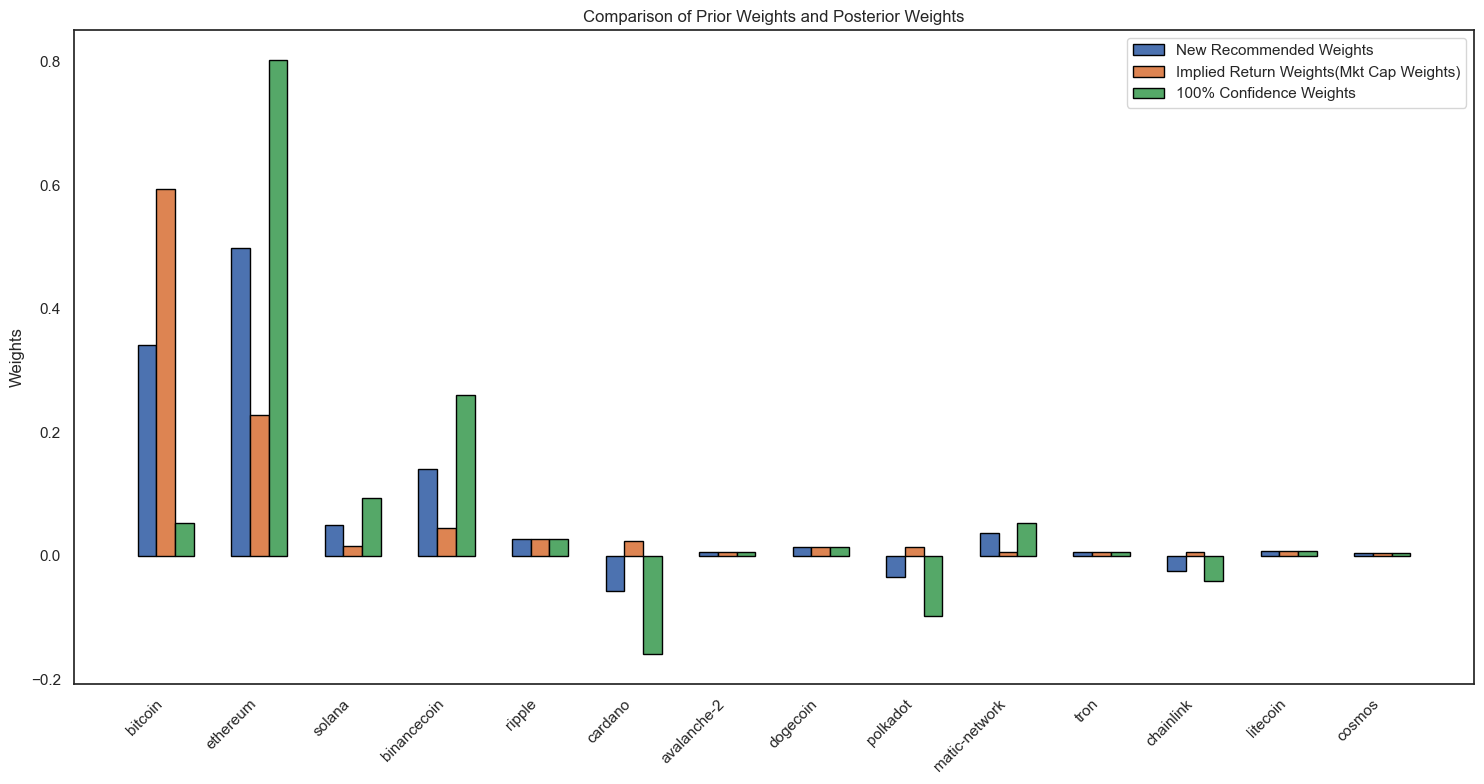

In [61]:

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(15, 8))
width = 0.2  # Width of the bars
num_bars = len(results3_df.columns)
indices = range(len(results3_df))

# Enumerate over columns to create grouped bars for each cryptocurrency
for i, col in enumerate(results3_df.columns):
    ax.bar([x + width*i for x in indices], results3_df[col], width, label=col, edgecolor='black')

# Add some customizations
ax.set_ylabel('Weights')
ax.set_title('Comparison of Prior Weights and Posterior Weights')
ax.set_xticks([r + width*(num_bars/2 - 0.5) for r in indices])
ax.set_xticklabels(results3_df.index, rotation=45, ha='right')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


-----------

#### Implied Confidence Level of Views

To determine the implied level of confidence in the views,<br>
we divide each weight difference $ (\hat{w} - w_{mkt}) $ by the corresponding maximum weight difference $ (w_{100\%} - w_{mkt}) $.


In [69]:
weight_difference = weights_new.flatten() - weights_pi.flatten()
max_difference = weights_confident.flatten() - weights_pi.flatten()
implied_confidence = weight_difference / max_difference

In [70]:
table4_df = pd.DataFrame({
    'Mkt Cap Weights': weights_pi.flatten(),
    'New Weight': weights_new.flatten(),
    'Difference New-MktCap' : weights_new.flatten() - weights_pi.flatten(),
    '100% Confidence Weights' : weights_confident.flatten(), 
    'Difference 100%-MktCap' : weights_confident.flatten() - weights_pi.flatten(),
    'Implied Confidence Level':implied_confidence
}, index=tickers)

# Format all numerical values as percentages
for col in table4_df.columns:
    table4_df[col] = table4_df[col].apply(lambda x: f'{x:.2%}' if isinstance(x, float) else x)

# Replace zeros and negative zeros with '--' in specific columns
zero_columns = ['Difference New-MktCap', 'Difference 100%-MktCap']
for col in zero_columns:
    table4_df[col] = table4_df[col].replace(['0.00%', '-0.00%'], '--')

# For 'Implied Confidence Level', set to '--' if either 'Difference' column is '--'
mask = (table4_df['Difference New-MktCap'] == '--') | (table4_df['Difference 100%-MktCap'] == '--')
table4_df.loc[mask, 'Implied Confidence Level'] = '--'

table4_df.reset_index(inplace=True)
table4_df.rename(columns={'index': 'Ticker'}, inplace=True)


table4_df

,Ticker,Mkt Cap Weights,New Weight,Difference New-MktCap,100% Confidence Weights,Difference 100%-MktCap,Implied Confidence Level
0,bitcoin,59.46%,34.14%,-25.32%,5.31%,-54.15%,46.77%
1,ethereum,22.80%,49.91%,27.11%,80.27%,57.48%,47.16%
2,solana,1.60%,5.02%,3.42%,9.32%,7.72%,44.29%
3,binancecoin,4.48%,14.07%,9.59%,26.13%,21.65%,44.29%
4,ripple,2.76%,2.76%,--,2.76%,--,--
5,cardano,2.36%,-5.73%,-8.09%,-15.91%,-18.26%,44.29%
6,avalanche-2,0.71%,0.71%,--,0.71%,--,--
7,dogecoin,1.44%,1.44%,--,1.44%,--,--
8,polkadot,1.43%,-3.49%,-4.92%,-9.67%,-11.11%,44.29%
9,matic-network,0.65%,3.72%,3.07%,5.34%,4.69%,65.43%



Considering the observed differences between the expressed confidence levels and the implied confidence levels, it may be beneficial to test different ω values. This testing would involve recalculating the New Combined Return Vector (${E}[R]$) and determining a revised set of recommended portfolio weights. <br>

Given that we're using the He & Littermann method for the scalar $\tau$, changing it's value to change $\Omega$ won't bring an effect to the New Combined Return Vector. We would have to directly change the views (Q) in order to see an effect. <br>

Hence, it would be beneficial to try another method for computing $\Omega$. 


--------

#### The tilt method

This method to compute $\Omega$ involves intuitive confidence levels, which are specified by the user.

$Tilt_k \approx (W_{100\%} - W_{mkt}) * C_k$

where $Tilt_k$ is the approximate tilt caused by the $k^{th}$ view $(N \times 1$), and $C_k$ is the confidence in the $k^{th}$ view.


In the absence of other views, the approximate recommended weight vector resulting from the view is:

$ W_{k,\%} \approx W_{mkt} + Tilt_k \quad  $

where

$ W_{k,\%} $ is the target weight vector based on the tilt caused by the $ k^{th} $ view $( N \times 1 )$.


This method involves several steps, which are the following:

Step 1: For each view $k$, calculate the New Combined Return Vector $E[R_{k,100\%}]$ using the Black-Litterman formula under 100% certainty, treating each view as if it was the only view.

$$ E[R_{k,100\%}] = \Pi + \tau \Sigma P_k' (\tau P_k \Sigma P_k')^{-1} (Q_k - P_k \Pi) \quad  $$

where

- $E[R_{k,100\%}]$ is the Expected Return Vector based on 100% confidence in the $k^{th}$ view ($N \times 1$);
- $P_k$ identifies the assets involved in the $k^{th}$ view ($1 \times N$);
- $Q_k$ is the $k^{th}$ View ($1 \times 1$).



Python:

In [71]:
tilt_returns = []

for i in range(k):
    # Calculate the tilt return for the ith view
    tilt_i = np.array(implied_return) + \
             np.array(tao * sigma) @ P[i].reshape(-1, 1) @ \
             np.linalg.inv(tao * P[i].reshape(1, -1) @ np.array(sigma) @ P[i].reshape(-1, 1)) @ \
             (Q[i] - P[i].reshape(1, -1) @ np.array(implied_return))
    
    # Append the flattened array of tilt returns for this view to the list
    tilt_returns.append(tilt_i.flatten())

# tilt_returns is now a list of arrays, each array represents the New Combined Vector for that view
tilt_returns = np.array(tilt_returns)
tilt_returns.shape

(4, 14)

Step 2: Calculate the weight vectors W_{k,100\%} using formula 2, which means we'll have 4 weight vectors(given that we have k=4 views).

Python:

In [72]:
weights_tilt = []
for i in range(k):
    weights_tilt.append(np.linalg.inv(lam*np.array(sigma))@tilt_returns[i])
weights_tilt = np.array(weights_tilt)
weights_tilt.shape

(4, 14)

Step 3: Compute
$D_{k,100\%} = W_{k,100\%} - W_{mkt}$ 

where

$D_{k,100\%}$ is the departure from market capitalization weight based on 100% confidence in $ k^{th} $ view $( N \times 1 )$.


In [73]:

D = np.array( weights_tilt - weights_pi.T , dtype='float')
D.shape

(4, 14)

In [74]:
np.round(D, 2)

array([[ 0.04, -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.  ,
        -0.  ,  0.  ,  0.  , -0.  ,  0.  ],
       [-0.52,  0.52, -0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  , -0.  ,
         0.  , -0.  , -0.  , -0.  ,  0.  ],
       [-0.  , -0.  ,  0.06,  0.17,  0.  , -0.15,  0.  , -0.  , -0.09,
         0.  , -0.  ,  0.  ,  0.  ,  0.  ],
       [-0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  ,
         0.07, -0.  , -0.07, -0.  , -0.  ]])

To visualize the results, we have the following table, where each row is a $D_{k,100\%}$ :

\begin{equation}
D = \begin{pmatrix}
0.04 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
-0.52 & 0.52 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0.06 & 0.17 & 0 & -0.15 & 0 & 0 & -0.09 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.07 & 0 & -0.07 & 0 & 0 
\end{pmatrix}
\end{equation}


Note: The assets of $W_{k,100\%}$ that are not part of the $ k^{th} $ view retain their original weight leading to a value of 0 for the elements of $D_{k,100\%}$ that are not part of the $ k^{th} $ view.

View 1, which is an absolute view towards bitcoin, is represented in row 1 of D, which shows how far away is the weight based on 100% confidence  and the market-cap weight.

Step 4: Compute

$
Tilt_k = D_{k,100\%} * C_k 
$

where

- $Tilt_k$ is the desired tilt (active weights) caused by the $k^{th}$ view ($N \times I$ ); and,
- $C_k$ is ($N \times 1$). It contains the Confidence Level of the view.


The assets that are involved in the view receive the confidence level of the $k^{th}$ view and the assets that are not part of the view are set to 0.


Let's use the following confidence levels:
View 1: 80%
View 2: 60%
View 3: 10%
View 4: 40%

In [75]:
C = [0.8, 0.6, 0.1, 0.4] 
Tilt = []
for i in range(k):
    Tilt.append(D[i]*C[i])
Tilt = np.array(Tilt)
np.round(Tilt, 2)

array([[ 0.03, -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.  ,
        -0.  ,  0.  ,  0.  , -0.  ,  0.  ],
       [-0.31,  0.31, -0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  , -0.  ,
         0.  , -0.  , -0.  , -0.  ,  0.  ],
       [-0.  , -0.  ,  0.01,  0.02,  0.  , -0.01,  0.  , -0.  , -0.01,
         0.  , -0.  ,  0.  ,  0.  ,  0.  ],
       [-0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  , -0.  ,
         0.03, -0.  , -0.03, -0.  , -0.  ]])

$$
Tilt = \begin{bmatrix}
0.03 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
-0.31 & 0.31 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0.01 & 0.02 & 0 & -0.01 & 0 & 0 & -0.01 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.03 & 0 & -0.03 & 0 & 0
\end{bmatrix}
$$


Each row of this matrix corresponds to $Tilt_k$ (transposed) .

Step 5: Compute the target weight vector $W_{k,\%}$ based on the tilt.

$$
W_{k,\%} = W_{mkt} + Tilt_k 
$$


In [76]:
weights_target = weights_pi + Tilt.T
weights_target.shape

(14, 4)

Step 6: Find $\omega_k$, which corresponds to the diagonal element of $\Omega$ in row k, by minimizing the sum of the squared differences between $W_{k,\%}$ and $W_k$.


$$
\min \sum (W_{k,\%} - W_k)^2 
$$
subject to $\omega_k > 0$.

where

$$
W_k = \left[ \lambda \mathbf{ \Sigma} \right]^{-1} \left[ (\mathbf{\tau \Sigma})^{-1} + P_k' \omega_k^{-1} P_k \right]^{-1} \left[ (\mathbf{\tau \Sigma})^{-1} \Pi + P_k' \omega_k^{-1} \mathbf{Q}_k \right] 
$$


In [79]:

tao = 0.000001 #Low scalar 

###### Omega method 1 ######

# Create an omega array of zeros with the shape (num_views, num_views)
omega1 = np.zeros((k, k))

# Calculate the variance for each view and assign it to the diagonal of omega
for i in range(k):
    p_i = P[i].reshape(1, -1)
    variance = np.array((p_i @ sigma @ p_i.T)).item() * tao  # Use .item() to get a scalar value
    omega1[i, i] = variance

####### Omega metho 2 #########

# Initialize an array to store the optimal omega values for each iteration
optimal_omega_values = np.zeros(4)
omega_0_initial = 1.0

for i in range(k):
    # Define the objective function for the current iteration
    def objective(omega_0, lam, sigma, tao, P_i, Q_i, implied_return, W_i_percent):
        A = np.linalg.inv(lam * sigma)
        B_inv = np.linalg.inv(np.linalg.inv(np.array(tao * sigma)) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ P_i.reshape(1, -1))
        B = np.linalg.inv(B_inv)
        C = np.linalg.inv(tao * sigma) @ np.array(implied_return) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ Q_i.reshape(1, 1)
        w_0 = A @ B @ C
        difference = W_i_percent - w_0.flatten()
        return np.sum(difference ** 2)

    # Perform the optimization using the i-th column of weights_target, and i-th elements of P and Q
    result = minimize(
        objective,                 # The objective function to minimize
        omega_0_initial,           # Initial guess for omega_0
        args=(lam, sigma, tao, P[i], Q[i], implied_return, weights_target[:, i]),  # Pass the i-th elements
        bounds=[(1e-6, None)],     # Bounds for omega_0 to ensure it's positive
        method='L-BFGS-B',         # Method that allows for bounds
        options={'disp': True}     # Display convergence messages
    )

    # Store the result
    if result.success:
        optimal_omega_values[i] = result.x[0]

optimal_omega = np.diag(optimal_omega_values)


In [80]:
optimal_omega

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000004e+00]])

Step 6 : Solve for the New Combined Return Vector

In [81]:

new_return1 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(omega1)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(omega1)@Q)
new_return2 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(optimal_omega)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(optimal_omega)@Q)
confident_return = np.array(implied_return) + tao*sigma@P.T@(np.linalg.inv((P@np.array(tao*sigma)@P.T)))@(Q-P@np.array(implied_return))

Let's put everything together:

### High Tau and 100% Confidence levels

In [82]:
#####
tao = 10

##### STEP 1. TILT RETURNS ########

tilt_returns = []

for i in range(k):
    # Calculate the tilt return for the ith view
    tilt_i = np.array(implied_return) + \
             np.array(tao * sigma) @ P[i].reshape(-1, 1) @ \
             np.linalg.inv(tao * P[i].reshape(1, -1) @ np.array(sigma) @ P[i].reshape(-1, 1)) @ \
             (Q[i] - P[i].reshape(1, -1) @ np.array(implied_return))
    
    # Append the flattened array of tilt returns for this view to the list
    tilt_returns.append(tilt_i.flatten())

# tilt_returns is now a list of arrays, each array represents the New Combined Vector for that view
tilt_returns = np.array(tilt_returns)

##### STEP 2. WEIGHTS OF THE TILT RETURNS ######
weights_tilt = []
for i in range(k):
    weights_tilt.append(np.linalg.inv(lam*np.array(sigma))@tilt_returns[i])
weights_tilt = np.array(weights_tilt)

##### STEP 3. DIFFERENCE WITH PRIOR #######
D = np.array( weights_tilt - weights_pi.T , dtype='float')

##### STEP 4. CONFIDENCE LEVELS AND TILT ######
C = [1, 1, 1, 1] 
Tilt = []
for i in range(k):
    Tilt.append(D[i]*C[i])
Tilt = np.array(Tilt)

##### STEP 5. TARGET WEIGHTS ######
weights_target = weights_pi + Tilt.T

 

###### Omega method 1 ######

# Create an omega array of zeros with the shape (num_views, num_views)
omega1 = np.zeros((k, k))

# Calculate the variance for each view and assign it to the diagonal of omega
for i in range(k):
    p_i = P[i].reshape(1, -1)
    variance = np.array((p_i @ sigma @ p_i.T)).item() * tao  # Use .item() to get a scalar value
    omega1[i, i] = variance

    
##### STEP 6  #####
####### Omega method 2 #########

# Initialize an array to store the optimal omega values for each iteration
optimal_omega_values = np.zeros(4)
omega_0_initial = 1.0
# Loop over the indices 0 to 3
for i in range(k):
    # Define the objective function for the current iteration
    def objective(omega_0, lam, sigma, tao, P_i, Q_i, implied_return, W_i_percent):
        A = np.linalg.inv(lam * sigma)
        B = np.linalg.inv(np.linalg.inv(np.array(tao * sigma)) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ P_i.reshape(1, -1))
        C = np.linalg.inv(tao * sigma) @ np.array(implied_return) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ Q_i.reshape(1, 1)
        w_0 = A @ B @ C
        difference = W_i_percent - w_0.flatten()
        return np.sum(difference ** 2)

    # Perform the optimization using the i-th column of weights_target, and i-th elements of P and Q
    result = minimize(
        objective,                 # The objective function to minimize
        omega_0_initial,           # Initial guess for omega_0
        args=(lam, sigma, tao, P[i], Q[i], implied_return, weights_target[:, i]),  # Pass the i-th elements
        bounds=[(1e-7, None)],     # Bounds for omega_0 to ensure it's positive
        method='L-BFGS-B',         # Method that allows for bounds
        options={'disp': True}     # Display convergence messages
    )

    # Store the result
    if result.success:
        optimal_omega_values[i] = result.x[0]

optimal_omega = np.diag(optimal_omega_values)


new_return1 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(omega1)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(omega1)@Q)
new_return2 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(optimal_omega)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(optimal_omega)@Q)
confident_return = np.array(implied_return) + tao*sigma@P.T@(np.linalg.inv((P@np.array(tao*sigma)@P.T)))@(Q-P@np.array(implied_return))

results4_df = pd.DataFrame({
    'New Combined Return E(R) 1st method': new_return1.flatten(),
    'New Combined Return E(R) 2nd method': new_return2.flatten(),
    '100% Confidence on Views Returns'   : np.array(confident_return).flatten(),
    'Implied Equilibrium Return Π': np.array(implied_return).flatten(),
}, index=tickers)

# Format the numbers to round them to two decimal places and convert to percentage
results4_df['New Combined Return E(R) 1st method'] = results4_df['New Combined Return E(R) 1st method'].apply(lambda x: f"{x:.2%}")
results4_df['New Combined Return E(R) 2nd method'] = results4_df['New Combined Return E(R) 2nd method'].apply(lambda x: f"{x:.2%}")
results4_df['100% Confidence on Views Returns'] = results4_df['100% Confidence on Views Returns'].apply(lambda x: f"{x:.2%}")
results4_df['Implied Equilibrium Return Π'] = results4_df['Implied Equilibrium Return Π'].apply(lambda x: f"{x:.2%}")

results4_df

,New Combined Return E(R) 1st method,New Combined Return E(R) 2nd method,100% Confidence on Views Returns,Implied Equilibrium Return Π
bitcoin,1.32%,1.34%,1.34%,1.29%
ethereum,1.76%,1.99%,1.99%,1.54%
solana,2.15%,2.50%,2.50%,1.82%
binancecoin,1.79%,2.04%,2.04%,1.56%
ripple,1.41%,1.60%,1.60%,1.25%
cardano,1.76%,1.86%,1.86%,1.64%
avalanche-2,2.37%,2.53%,2.53%,2.18%
dogecoin,2.57%,3.04%,3.04%,2.14%
polkadot,1.63%,1.73%,1.73%,1.53%
matic-network,2.10%,2.43%,2.43%,1.72%


This 1st table shows the expected returns (our Posterior) using method 1 and 2 to compute $\Omega$. <br>
In the 3rd and 4th column, we have the 100% Confidence on Views Vector and the Implied Equilibrium Returns (the Prior). <br>
In this example, I set the value of $\tau$ to 10, which is a high value. <br> 
A high value of $\tau$ increases the weight given towards the views. <br>
In addition, the confidence levels are set to 100% to all the views. <br>
As you can see, the posterior using the 2nd method (col.2) is equal to col.3.<br>


### Low Tau, 100% Confidence Levels

Now let's see what happens if we set a low $\tau$ but with 100% confidence levels:

In [83]:
#####
tao = 0.000001

##### STEP 1. TILT RETURNS ########

tilt_returns = []

for i in range(k):
    # Calculate the tilt return for the ith view
    tilt_i = np.array(implied_return) + \
             np.array(tao * sigma) @ P[i].reshape(-1, 1) @ \
             np.linalg.inv(tao * P[i].reshape(1, -1) @ np.array(sigma) @ P[i].reshape(-1, 1)) @ \
             (Q[i] - P[i].reshape(1, -1) @ np.array(implied_return))
    
    # Append the flattened array of tilt returns for this view to the list
    tilt_returns.append(tilt_i.flatten())

# tilt_returns is now a list of arrays, each array represents the New Combined Vector for that view
tilt_returns = np.array(tilt_returns)

##### STEP 2. WEIGHTS OF THE TILT RETURNS ######
weights_tilt = []
for i in range(k):
    weights_tilt.append(np.linalg.inv(lam*np.array(sigma))@tilt_returns[i])
weights_tilt = np.array(weights_tilt)

##### STEP 3. DIFFERENCE WITH PRIOR #######
D = np.array( weights_tilt - weights_pi.T , dtype='float')

##### STEP 4. CONFIDENCE LEVELS AND TILT ######
C = [1, 1, 1, 1] 
Tilt = []
for i in range(k):
    Tilt.append(D[i]*C[i])
Tilt = np.array(Tilt)

##### STEP 5. TARGET WEIGHTS ######
weights_target = weights_pi + Tilt.T

 

###### Omega method 1 ######

# Create an omega array of zeros with the shape (num_views, num_views)
omega1 = np.zeros((k, k))

# Calculate the variance for each view and assign it to the diagonal of omega
for i in range(k):
    p_i = P[i].reshape(1, -1)
    variance = np.array((p_i @ sigma @ p_i.T)).item() * tao  # Use .item() to get a scalar value
    omega1[i, i] = variance

    
##### STEP 6  #####
####### Omega method 2 #########

# Initialize an array to store the optimal omega values for each iteration
optimal_omega_values = np.zeros(4)
omega_0_initial = 1.0
# Loop over the indices 0 to 3
for i in range(k):
    # Define the objective function for the current iteration
    def objective(omega_0, lam, sigma, tao, P_i, Q_i, implied_return, W_i_percent):
        A = np.linalg.inv(lam * sigma)
        B = np.linalg.inv(np.linalg.inv(np.array(tao * sigma)) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ P_i.reshape(1, -1))
        C = np.linalg.inv(tao * sigma) @ np.array(implied_return) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ Q_i.reshape(1, 1)
        w_0 = A @ B @ C
        difference = W_i_percent - w_0.flatten()
        return np.sum(difference ** 2)

    # Perform the optimization using the i-th column of weights_target, and i-th elements of P and Q
    result = minimize(
        objective,                 # The objective function to minimize
        omega_0_initial,           # Initial guess for omega_0
        args=(lam, sigma, tao, P[i], Q[i], implied_return, weights_target[:, i]),  # Pass the i-th elements
        bounds=[(1e-7, None)],     # Bounds for omega_0 to ensure it's positive
        method='L-BFGS-B',         # Method that allows for bounds
        options={'disp': True}     # Display convergence messages
    )

    # Store the result
    if result.success:
        optimal_omega_values[i] = result.x[0]

optimal_omega = np.diag(optimal_omega_values)


new_return1 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(omega1)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(omega1)@Q)
new_return2 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(optimal_omega)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(optimal_omega)@Q)
confident_return = np.array(implied_return) + tao*sigma@P.T@(np.linalg.inv((P@np.array(tao*sigma)@P.T)))@(Q-P@np.array(implied_return))

results4_df = pd.DataFrame({
    'New Combined Return E(R) 1st method': new_return1.flatten(),
    'New Combined Return E(R) 2nd method': new_return2.flatten(),
    '100% Confidence on Views Returns'   : np.array(confident_return).flatten(),
    'Implied Equilibrium Return Π': np.array(implied_return).flatten(),
}, index=tickers)

# Format the numbers to round them to two decimal places and convert to percentage
results4_df['New Combined Return E(R) 1st method'] = results4_df['New Combined Return E(R) 1st method'].apply(lambda x: f"{x:.2%}")
results4_df['New Combined Return E(R) 2nd method'] = results4_df['New Combined Return E(R) 2nd method'].apply(lambda x: f"{x:.2%}")
results4_df['100% Confidence on Views Returns'] = results4_df['100% Confidence on Views Returns'].apply(lambda x: f"{x:.2%}")
results4_df['Implied Equilibrium Return Π'] = results4_df['Implied Equilibrium Return Π'].apply(lambda x: f"{x:.2%}")

results4_df

,New Combined Return E(R) 1st method,New Combined Return E(R) 2nd method,100% Confidence on Views Returns,Implied Equilibrium Return Π
bitcoin,1.32%,1.29%,1.34%,1.29%
ethereum,1.76%,1.54%,1.99%,1.54%
solana,2.15%,1.82%,2.50%,1.82%
binancecoin,1.79%,1.56%,2.04%,1.56%
ripple,1.41%,1.25%,1.60%,1.25%
cardano,1.76%,1.64%,1.86%,1.64%
avalanche-2,2.37%,2.18%,2.53%,2.18%
dogecoin,2.57%,2.14%,3.04%,2.14%
polkadot,1.63%,1.53%,1.73%,1.53%
matic-network,2.10%,1.72%,2.43%,1.72%


Setting low $\tau$ and high confidence levels leads to a posterior equal to the prior.

### High Tau, 1% confidence levels

Now let's set a high $\tau$ and low confidence levels (1%):

In [85]:
#####
tao = 10

##### STEP 1. TILT RETURNS ########

tilt_returns = []

for i in range(k):
    # Calculate the tilt return for the ith view
    tilt_i = np.array(implied_return) + \
             np.array(tao * sigma) @ P[i].reshape(-1, 1) @ \
             np.linalg.inv(tao * P[i].reshape(1, -1) @ np.array(sigma) @ P[i].reshape(-1, 1)) @ \
             (Q[i] - P[i].reshape(1, -1) @ np.array(implied_return))
    
    # Append the flattened array of tilt returns for this view to the list
    tilt_returns.append(tilt_i.flatten())

# tilt_returns is now a list of arrays, each array represents the New Combined Vector for that view
tilt_returns = np.array(tilt_returns)

##### STEP 2. WEIGHTS OF THE TILT RETURNS ######
weights_tilt = []
for i in range(k):
    weights_tilt.append(np.linalg.inv(lam*np.array(sigma))@tilt_returns[i])
weights_tilt = np.array(weights_tilt)

##### STEP 3. DIFFERENCE WITH PRIOR #######
D = np.array( weights_tilt - weights_pi.T , dtype='float')

##### STEP 4. CONFIDENCE LEVELS AND TILT ######
C = [0.01, 0.01, 0.01, 0.01] 
Tilt = []
for i in range(k):
    Tilt.append(D[i]*C[i])
Tilt = np.array(Tilt)

##### STEP 5. TARGET WEIGHTS ######
weights_target = weights_pi + Tilt.T

 

###### Omega method 1 ######

# Create an omega array of zeros with the shape (num_views, num_views)
omega1 = np.zeros((k, k))

# Calculate the variance for each view and assign it to the diagonal of omega
for i in range(k):
    p_i = P[i].reshape(1, -1)
    variance = np.array((p_i @ sigma @ p_i.T)).item() * tao  # Use .item() to get a scalar value
    omega1[i, i] = variance

    
##### STEP 6  #####
####### Omega method 2 #########

# Initialize an array to store the optimal omega values for each iteration
optimal_omega_values = np.zeros(4)
omega_0_initial = 1.0
# Loop over the indices 0 to 3
for i in range(k):
    # Define the objective function for the current iteration
    def objective(omega_0, lam, sigma, tao, P_i, Q_i, implied_return, W_i_percent):
        A = np.linalg.inv(lam * sigma)
        B = np.linalg.inv(np.linalg.inv(np.array(tao * sigma)) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ P_i.reshape(1, -1))
        C = np.linalg.inv(tao * sigma) @ np.array(implied_return) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ Q_i.reshape(1, 1)
        w_0 = A @ B @ C
        difference = W_i_percent - w_0.flatten()
        return np.sum(difference ** 2)

    # Perform the optimization using the i-th column of weights_target, and i-th elements of P and Q
    result = minimize(
        objective,                 # The objective function to minimize
        omega_0_initial,           # Initial guess for omega_0
        args=(lam, sigma, tao, P[i], Q[i], implied_return, weights_target[:, i]),  # Pass the i-th elements
        bounds=[(1e-7, None)],     # Bounds for omega_0 to ensure it's positive
        method='L-BFGS-B',         # Method that allows for bounds
        options={'disp': True}     # Display convergence messages
    )

    # Store the result
    if result.success:
        optimal_omega_values[i] = result.x[0]

optimal_omega = np.diag(optimal_omega_values)


new_return1 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(omega1)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(omega1)@Q)
new_return2 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(optimal_omega)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(optimal_omega)@Q)
confident_return = np.array(implied_return) + tao*sigma@P.T@(np.linalg.inv((P@np.array(tao*sigma)@P.T)))@(Q-P@np.array(implied_return))

results4_df = pd.DataFrame({
    'New Combined Return E(R) 1st method': new_return1.flatten(),
    'New Combined Return E(R) 2nd method': new_return2.flatten(),
    '100% Confidence on Views Returns'   : np.array(confident_return).flatten(),
    'Implied Equilibrium Return Π': np.array(implied_return).flatten(),
}, index=tickers)

# Format the numbers to round them to two decimal places and convert to percentage
results4_df['New Combined Return E(R) 1st method'] = results4_df['New Combined Return E(R) 1st method'].apply(lambda x: f"{x:.2%}")
results4_df['New Combined Return E(R) 2nd method'] = results4_df['New Combined Return E(R) 2nd method'].apply(lambda x: f"{x:.2%}")
results4_df['100% Confidence on Views Returns'] = results4_df['100% Confidence on Views Returns'].apply(lambda x: f"{x:.2%}")
results4_df['Implied Equilibrium Return Π'] = results4_df['Implied Equilibrium Return Π'].apply(lambda x: f"{x:.2%}")

results4_df

,New Combined Return E(R) 1st method,New Combined Return E(R) 2nd method,100% Confidence on Views Returns,Implied Equilibrium Return Π
bitcoin,1.32%,1.29%,1.34%,1.29%
ethereum,1.76%,1.54%,1.99%,1.54%
solana,2.15%,1.84%,2.50%,1.82%
binancecoin,1.79%,1.58%,2.04%,1.56%
ripple,1.41%,1.26%,1.60%,1.25%
cardano,1.76%,1.65%,1.86%,1.64%
avalanche-2,2.37%,2.20%,2.53%,2.18%
dogecoin,2.57%,2.16%,3.04%,2.14%
polkadot,1.63%,1.54%,1.73%,1.53%
matic-network,2.10%,1.75%,2.43%,1.72%


We see a posterior very close to the prior. <br>
The intuition is very clear, high $\tau$ leads to more weight towrds the views, however since we're very uncertain about those views, the posterior stays close to the prior.

Note: The Combined Return vector using the 1st method (ie. setting $\omega =  \mathbf{p}_k \Sigma \mathbf{p}_k^T  \times \tau$) doesn't change when $\tau$ is changed, showing a potential limit of that method to compute $\Omega$.

Being able to set an intuitive confidence level may be helpful because it lets the user insert some kind of bias. <br>

For example, in the context of cryptocurrencies, the news around the approval of the ETF of Bitcoin and the upcoming halvening may provide a lot of bias to investors, which can be incorporated into the model. <br>

Using traditional mean-variance models, which are frequentist, don't let you incorporate this kind of information, making those models very sensitive to the input parameters(expected returns, variances, and covariances).

--------

#### Weights Comparison

For this comparison, I will be setting the following assumptions: <br>
Confidence on the views: 100%, 70%, 10%, 80% respectively, <br>
$\tau$ = 1 (Decent amount of weight towards the views).<br>

In [103]:
#####
tao = 1

##### STEP 1. TILT RETURNS ########

tilt_returns = []

for i in range(k):
    # Calculate the tilt return for the ith view
    tilt_i = np.array(implied_return) + \
             np.array(tao * sigma) @ P[i].reshape(-1, 1) @ \
             np.linalg.inv(tao * P[i].reshape(1, -1) @ np.array(sigma) @ P[i].reshape(-1, 1)) @ \
             (Q[i] - P[i].reshape(1, -1) @ np.array(implied_return))
    
    # Append the flattened array of tilt returns for this view to the list
    tilt_returns.append(tilt_i.flatten())

# tilt_returns is now a list of arrays, each array represents the New Combined Vector for that view
tilt_returns = np.array(tilt_returns)

##### STEP 2. WEIGHTS OF THE TILT RETURNS ######
weights_tilt = []
for i in range(k):
    weights_tilt.append(np.linalg.inv(lam*np.array(sigma))@tilt_returns[i])
weights_tilt = np.array(weights_tilt)

##### STEP 3. DIFFERENCE WITH PRIOR #######
D = np.array( weights_tilt - weights_pi.T , dtype='float')

##### STEP 4. CONFIDENCE LEVELS AND TILT ######
C = [1, 0.7, 0.1, 0.8] 
Tilt = []
for i in range(k):
    Tilt.append(D[i]*C[i])
Tilt = np.array(Tilt)

##### STEP 5. TARGET WEIGHTS ######
weights_target = weights_pi + Tilt.T

 

###### Omega method 1 ######

# Create an omega array of zeros with the shape (num_views, num_views)
omega1 = np.zeros((k, k))

# Calculate the variance for each view and assign it to the diagonal of omega
for i in range(k):
    p_i = P[i].reshape(1, -1)
    variance = np.array((p_i @ sigma @ p_i.T)).item() * tao  # Use .item() to get a scalar value
    omega1[i, i] = variance

    
##### STEP 6  #####
####### Omega method 2 #########

# Initialize an array to store the optimal omega values for each iteration
optimal_omega_values = np.zeros(4)
omega_0_initial = 1.0
# Loop over the indices 0 to 3
for i in range(k):
    # Define the objective function for the current iteration
    def objective(omega_0, lam, sigma, tao, P_i, Q_i, implied_return, W_i_percent):
        A = np.linalg.inv(lam * sigma)
        B = np.linalg.inv(np.linalg.inv(np.array(tao * sigma)) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ P_i.reshape(1, -1))
        C = np.linalg.inv(tao * sigma) @ np.array(implied_return) + P_i.reshape(1, -1).T @ (1 / omega_0).reshape(1,1) @ Q_i.reshape(1, 1)
        w_0 = A @ B @ C
        difference = W_i_percent - w_0.flatten()
        return np.sum(difference ** 2)

    # Perform the optimization using the i-th column of weights_target, and i-th elements of P and Q
    result = minimize(
        objective,                 # The objective function to minimize
        omega_0_initial,           # Initial guess for omega_0
        args=(lam, sigma, tao, P[i], Q[i], implied_return, weights_target[:, i]),  # Pass the i-th elements
        bounds=[(1e-7, None)],     # Bounds for omega_0 to ensure it's positive
        method='L-BFGS-B',         # Method that allows for bounds
        options={'disp': True}     # Display convergence messages
    )

    # Store the result
    if result.success:
        optimal_omega_values[i] = result.x[0]

optimal_omega = np.diag(optimal_omega_values)


new_return1 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(omega1)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(omega1)@Q)
new_return2 = np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(optimal_omega)@P) @ ( np.linalg.inv(tao*sigma)@np.array(implied_return) + P.T@np.linalg.inv(optimal_omega)@Q)
confident_return = np.array(implied_return) + tao*sigma@P.T@(np.linalg.inv((P@np.array(tao*sigma)@P.T)))@(Q-P@np.array(implied_return))

weights_new1 = np.array(np.linalg.inv(lam*np.array(sigma))@new_return1)
weights_confident = np.array(np.linalg.inv(lam*np.array(sigma))@confident_return)

In [109]:
results4_df = pd.DataFrame({
    'New Combined Return E(R)': new_return2.flatten(),
    '100% Confidence on Views Returns'   : np.array(confident_return).flatten(),
    'Implied Equilibrium Return Π': np.array(implied_return).flatten(),
}, index=tickers)

# Format the numbers to round them to two decimal places and convert to percentage
results4_df['New Combined Return E(R)'] = results4_df['New Combined Return E(R)'].apply(lambda x: f"{x:.2%}")
results4_df['100% Confidence on Views Returns'] = results4_df['100% Confidence on Views Returns'].apply(lambda x: f"{x:.2%}")
results4_df['Implied Equilibrium Return Π'] = results4_df['Implied Equilibrium Return Π'].apply(lambda x: f"{x:.2%}")

results4_df

,New Combined Return E(R),100% Confidence on Views Returns,Implied Equilibrium Return Π
bitcoin,1.30%,1.34%,1.29%
ethereum,1.83%,1.99%,1.54%
solana,2.14%,2.50%,1.82%
binancecoin,1.70%,2.04%,1.56%
ripple,1.42%,1.60%,1.25%
cardano,1.86%,1.86%,1.64%
avalanche-2,2.43%,2.53%,2.18%
dogecoin,2.60%,3.04%,2.14%
polkadot,1.67%,1.73%,1.53%
matic-network,2.23%,2.43%,1.72%


In [114]:
weights_new2 = np.array(np.linalg.inv(lam*np.array(sigma))@new_return2)

In [ ]:
'Historical Weights' : np.array(weights_historical).flatten(),
'MVDA10 CAPM Weights' : np.array(weights_bitwise).flatten()

In [123]:
weights_df = pd.DataFrame({
    'Posterior Weights': weights_new2.flatten(),
    'Prior Weights': weights_pi.flatten(),
    '100% Confidence Weights' : weights_confident.flatten(),
}, index=tickers)

weights_df

,Posterior Weights,Prior Weights,100% Confidence Weights
bitcoin,0.233349,0.594589,0.053101
ethereum,0.589431,0.227982,0.802737
solana,0.022987,0.015973,0.093185
binancecoin,0.064454,0.044789,0.26129
ripple,0.027619,0.027619,0.027619
cardano,0.00697,0.02356,-0.159075
avalanche-2,0.007068,0.007068,0.007068
dogecoin,0.014431,0.014431,0.014431
polkadot,0.004239,0.014329,-0.096749
matic-network,0.058349,0.006508,0.053365


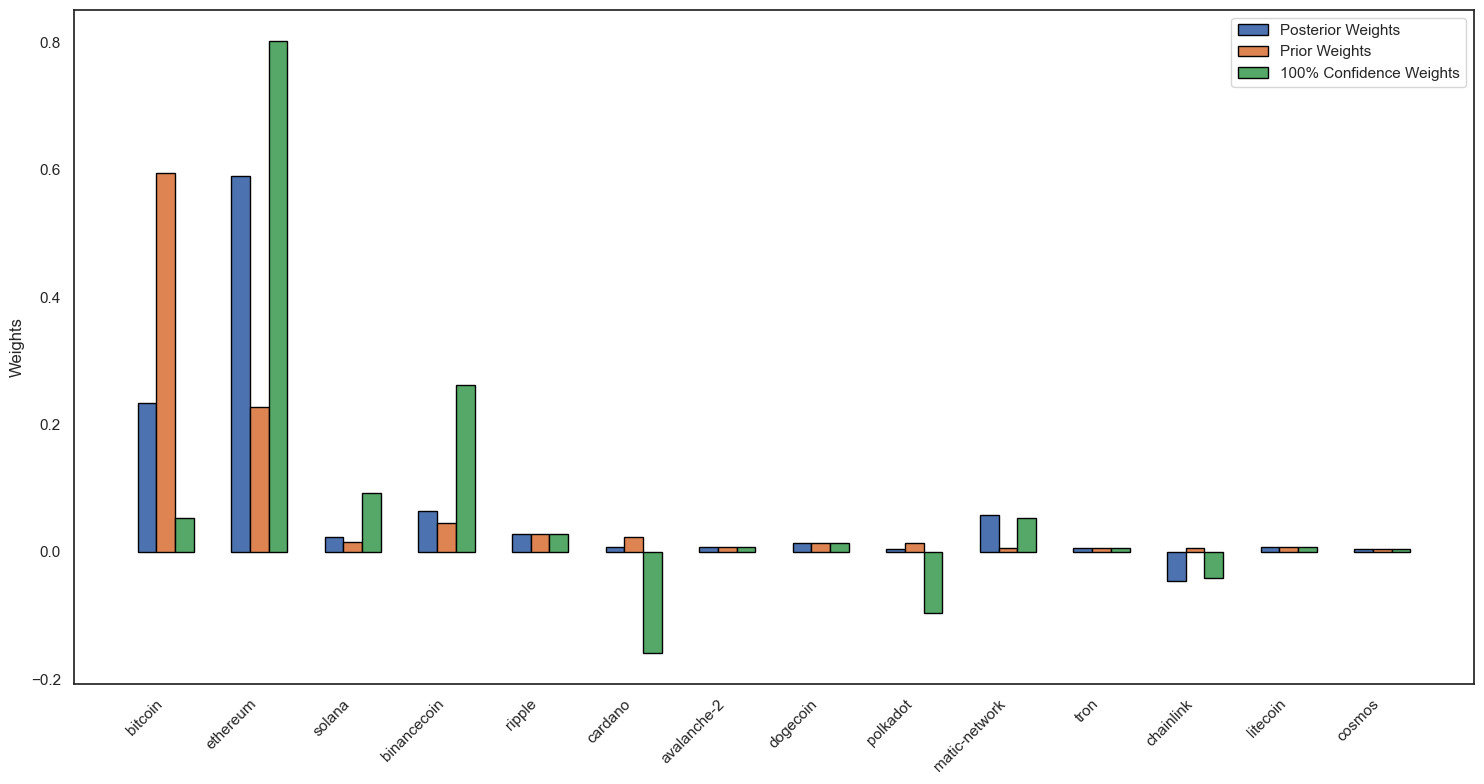

In [124]:
# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(15, 8))
width = 0.2  # Width of the bars
num_bars = len(weights_df.columns)
indices = range(len(weights_df))

# Enumerate over columns to create grouped bars for each cryptocurrency
for i, col in enumerate(weights_df.columns):
    ax.bar([x + width*i for x in indices], weights_df[col], width, label=col, edgecolor='black')

# Add some customizations
ax.set_ylabel('Weights')
ax.set_xticks([r + width*(num_bars/2 - 0.5) for r in indices])
ax.set_xticklabels(weights_df.index, rotation=45, ha='right')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Portfolio statistics, weekly basis

In [183]:
### Excess Returns
mktcap_excess = float(weights_pi.T @ np.array(implied_return)) - rf
bl_excess = float(weights_new2.T @ new_return2) - rf
historical_excess = float(weights_historical.T @ np.array(historical_df)) - rf

### Variances
var_pi = float(np.array(weights_pi.T@sigma@weights_pi))
var_bl = float(np.array(weights_new2.T@sigma@weights_new2))
var_historical = float(np.array(weights_historical.T@sigma@weights_historical))

### Beta
mktcap_weekly = np.array((weights_pi.T @ returns_df.tail(171).T), dtype='float64')
bl_weekly = np.array(weights_new2.T @ returns_df.tail(171).T, dtype='float64')
historical_weekly = np.array(weights_historical.T @ returns_df.tail(171).T, dtype='float64')

beta_mktcap = np.linalg.inv(mktcap_weekly @ mktcap_weekly.T) @ mktcap_weekly @ mktcap_weekly.T
beta_bl = np.linalg.inv(mktcap_weekly @ mktcap_weekly.T) @ mktcap_weekly @ bl_weekly.T
beta_historical = np.linalg.inv(mktcap_weekly @ mktcap_weekly.T) @ mktcap_weekly @ historical_weekly.T

### Residual Return
theta_p = np.array(bl_excess - beta_bl*mktcap_excess)
theta_p_hist = np.array(historical_excess - beta_historical*mktcap_excess)

### Residual Risk
omega_p = np.array(var_bl - beta_bl**2*var_pi)**(1/2)
omega_p_hist = np.array(var_historical - beta_historical**2*var_pi)**(1/2)

### Active Ret
active_ret = bl_excess-mktcap_excess
active_ret_hist = historical_excess-mktcap_excess

### Active Risk
active_risk = (omega_p**2+((beta_bl-1)**2)*var_pi)**(1/2)
active_risk_hist = (omega_p_hist**2+((beta_historical-1)**2)*var_pi)**(1/2)

### Sharpe Ratio
sharpe_mktcap = (mktcap_excess-rf)/(var_pi)**(1/2)
sharpe_bl = (bl_excess-rf)/(var_bl)**(1/2)
sharpe_hist = (historical_excess-rf)/(var_historical)**(1/2)

### Tracking Error:
TE = np.std(bl_weekly - mktcap_weekly, ddof=1)
TE_hist = np.std(historical_weekly - mktcap_weekly, ddof=1)

### Information Ratio
IR = active_ret / TE
IR_hist = active_ret_hist / TE_hist

######
pf_statistics = pd.DataFrame({
       'Market Capitalization-Weighted Portfolio' : [mktcap_excess],
       'Black-Litterman Portfolio' : [bl_excess],
       'Historical' : [historical_excess]
}, index = ['Excess Returns'])

pf_statistics.loc['Variance'] = [var_pi  , var_bl, var_historical]

pf_statistics.loc['Std. Deviation'] = [var_pi**(1/2)  , var_bl**(1/2), var_historical**(1/2)]

pf_statistics.loc['Beta'] = [float(beta_mktcap)  , float(beta_bl), float(beta_historical)]

pf_statistics.loc['Residual Return'] = [ '--' , float(theta_p), float(theta_p_hist)]

pf_statistics.loc['Residual Risk'] = [ '--' , float(omega_p), float(omega_p_hist)]

pf_statistics.loc['Active Return'] = [ '--' , active_ret, active_ret_hist]

pf_statistics.loc['Active Risk'] = [ '--' , float(active_risk), float(active_risk_hist)]

pf_statistics.loc['Sharpe Ratio'] = [sharpe_mktcap , sharpe_bl, sharpe_hist]

pf_statistics.loc['Information Ratio'] = [ '--' , float(IR), float(IR_hist)]

pf_statistics.loc['Excess Returns', :] = pf_statistics.loc['Excess Returns', :].apply(lambda x: f"{x:.2%}")

pf_statistics.loc['Std. Deviation', :] = pf_statistics.loc['Std. Deviation', :].apply(lambda x: f"{x:.3%}")

pf_statistics.loc['Residual Return', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Residual Return', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Residual Risk', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Residual Risk', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Active Return', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Active Return', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Active Risk', 'Black-Litterman Portfolio'] = str(round(pf_statistics.loc['Active Risk', 'Black-Litterman Portfolio'],4)) + '%'

pf_statistics.loc['Residual Return', 'Historical'] = str(round(pf_statistics.loc['Residual Return', 'Historical'],4)) + '%'

pf_statistics.loc['Residual Risk', 'Historical'] = str(round(pf_statistics.loc['Residual Risk', 'Historical'],4)) + '%'

pf_statistics.loc['Active Return', 'Historical'] = str(round(pf_statistics.loc['Active Return', 'Historical'],4)) + '%'

pf_statistics.loc['Active Risk', 'Historical'] = str(round(pf_statistics.loc['Active Risk', 'Historical'],4)) + '%'

pf_statistics

,Market Capitalization-Weighted Portfolio,Black-Litterman Portfolio,Historical
Excess Returns,1.40%,1.74%,4.23%
Variance,0.006485,0.008043,0.019617
Std. Deviation,8.053%,8.968%,14.006%
Beta,1.0,1.08131,1.059696
Residual Return,--,0.0022%,0.0275%
Residual Risk,--,0.0214%,0.1111%
Active Return,--,0.0034%,0.0283%
Active Risk,--,0.0224%,0.1112%
Sharpe Ratio,0.173781,0.193521,0.302237
Information Ratio,--,0.141796,0.24728


---------------

### Visualization of the Distribution

New Combined Return Distribution

$$ N \sim (\mathbb{E}[R], [(\tau\Sigma)^{-1} + (P' \Omega^{-1} P)]^{-1}) $$



----------

##### The posterior distribution of expected returns in the Black-Litterman model <br>

In the following chunks, I will be computing the Posterior Distribution by generating random samples constructed using the Posterior Mean and the Posterior Covariance Matrix.

1) Posterior Mean: The posterior mean is simply the New Combined Return Vector E(R) that we previously computed using the Black-Littermann formula.

In [495]:
new_return2.shape

(14, 1)

2. Posterior Covariance Matrix, which incorporates the uncertainty of the investor's views is given by:
$$
\Sigma_{\text{posterior}} = [(\tau\Sigma)^{-1} + (P' \Omega^{-1} P)]^{-1}
$$


In [131]:
sigma_posterior = (np.linalg.inv(np.linalg.inv(tao*np.array(sigma)) +  P.T@np.linalg.inv(omega)@P))
sigma_posterior.shape

(14, 14)

3. Simulate the Posterior Distribution: With the posterior mean and posterior covariance matrix, we can simulate the posterior distribution of returns using a Monte Carlo approach. This involves drawing random samples from a multivariate normal distribution defined by the posterior mean and posterior covariance matrix.

In [157]:
# Number of simulations
num_simulations = 10000
# Simulating the posterior distribution
simulated_returns = np.random.multivariate_normal(np.squeeze(new_return2).astype('float64')*52, sigma_posterior*52, num_simulations)

Analyzing the results:

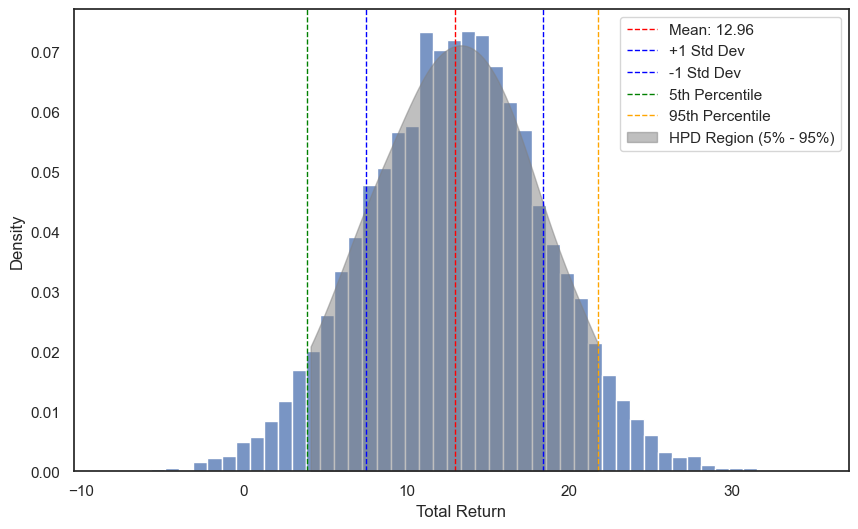

In [177]:
# Calculate portfolio returns for each sample
portfolio_returns = np.sum(simulated_returns, axis=1)

# Compute mean, standard deviation, and percentiles
mean_return = np.mean(portfolio_returns)
std_deviation = np.std(portfolio_returns)
percentile_5 = np.percentile(portfolio_returns, 5)
percentile_95 = np.percentile(portfolio_returns, 95)

# Calculate the density for the Highest Posterior Density (HPD) region
density = gaussian_kde(portfolio_returns)
xs = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 200)
density.covariance_factor = lambda : .25
density._compute_covariance()

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(portfolio_returns, bins=50, kde=False, stat="density")
plt.xlabel('Total Return')
plt.ylabel('Density')

# Descriptive statistics and HPD region
plt.axvline(mean_return, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_return:.2f}')
plt.axvline(mean_return + std_deviation, color='blue', linestyle='dashed', linewidth=1, label=f'+1 Std Dev')
plt.axvline(mean_return - std_deviation, color='blue', linestyle='dashed', linewidth=1, label=f'-1 Std Dev')
plt.axvline(percentile_5, color='green', linestyle='dashed', linewidth=1, label=f'5th Percentile')
plt.axvline(percentile_95, color='orange', linestyle='dashed', linewidth=1, label=f'95th Percentile')
plt.fill_between(xs, density(xs), where=(xs > percentile_5) & (xs < percentile_95), color="gray", alpha=0.5, label='HPD Region (5% - 95%)')

plt.legend()
plt.show()

### Hyp Testing

In [178]:
# Hypothesis testing
prob_H1 = np.mean(portfolio_returns > float(np.mean(implied_return)))
prob_H2 = 1 - prob_H1

print(f"Probability of H1 (mean return > pi): {prob_H1}")
print(f"Probability of H2 (mean return <= pi): {prob_H2}")

Probability of H1 (mean return > pi): 0.9908
Probability of H2 (mean return <= pi): 0.009199999999999986


C:\Users\Martin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
